In [1]:
import cv2
import numpy as np
import pandas as pd
from time import time, sleep
from os import makedirs, path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.utils import shuffle
import tensorflow.keras as keras

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Data

In [2]:
classes = np.loadtxt('cifar/labels.txt', dtype=str).tolist()
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [3]:
img_list = glob.glob('cifar/train/*.png')
img_list.sort()
img_list[:20]

['cifar/train/0_frog.png',
 'cifar/train/10000_automobile.png',
 'cifar/train/10001_frog.png',
 'cifar/train/10002_frog.png',
 'cifar/train/10003_ship.png',
 'cifar/train/10004_ship.png',
 'cifar/train/10005_cat.png',
 'cifar/train/10006_deer.png',
 'cifar/train/10007_frog.png',
 'cifar/train/10008_airplane.png',
 'cifar/train/10009_frog.png',
 'cifar/train/1000_truck.png',
 'cifar/train/10010_airplane.png',
 'cifar/train/10011_cat.png',
 'cifar/train/10012_frog.png',
 'cifar/train/10013_frog.png',
 'cifar/train/10014_dog.png',
 'cifar/train/10015_deer.png',
 'cifar/train/10016_ship.png',
 'cifar/train/10017_cat.png']

In [4]:
def load_png(img_list):
    imgs = []
    labels = []
    for i in range(len(img_list)):
        # img
        img = cv2.imread(img_list[i])
        #label
        name = img_list[i].split('_')[-1][:-4]
        label = classes.index(name)

        imgs.append(img)
        labels.append(label)
    return imgs, labels

imgs, labels = load_png(img_list)


img shape: (32, 32, 3)
8 - ship


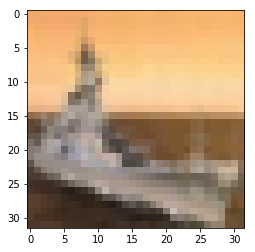

4 - deer


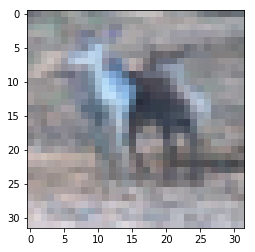

1 - automobile


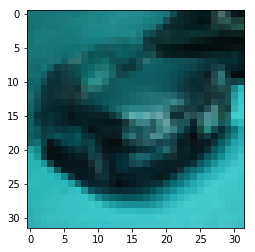

8 - ship


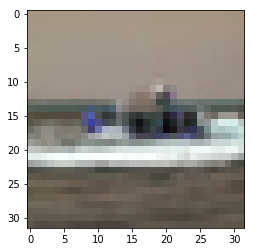

7 - horse


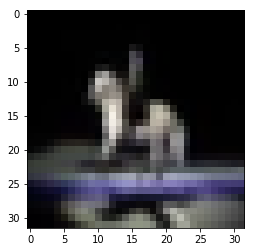

6 - frog


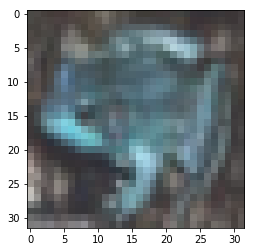

8 - ship


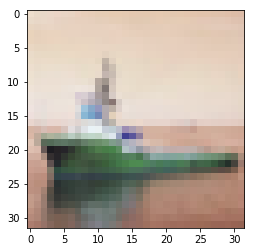

5 - dog


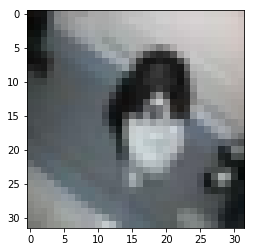

6 - frog


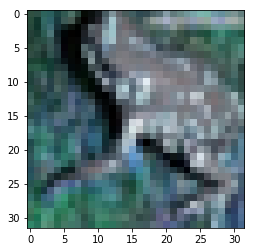

5 - dog


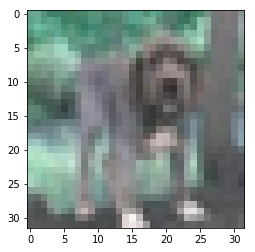

2 - bird


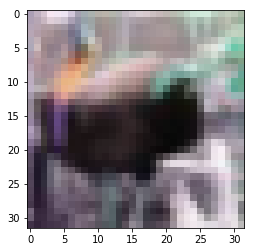

1 - automobile


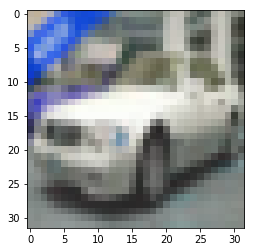

0 - airplane


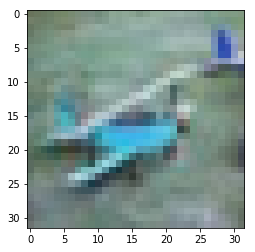

5 - dog


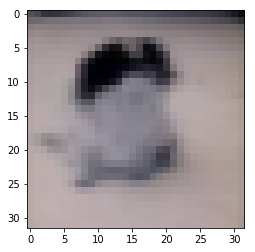

1 - automobile


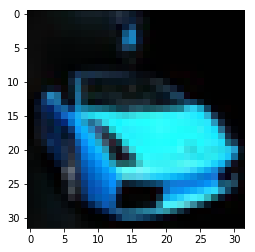

4 - deer


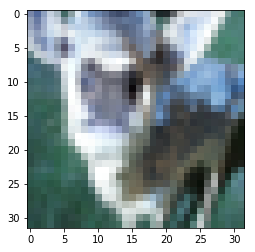

4 - deer


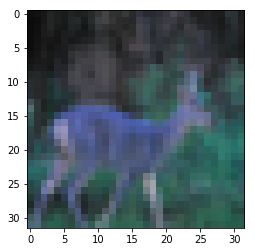

2 - bird


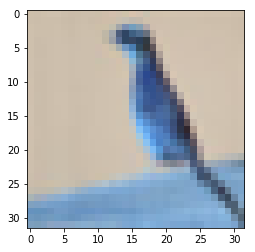

4 - deer


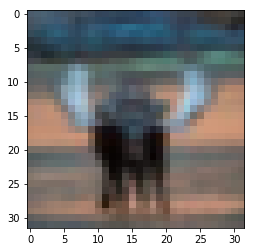

4 - deer


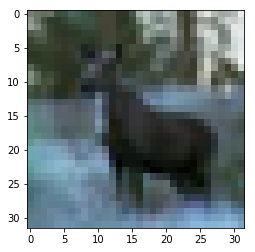

In [5]:
print('img shape:', imgs[2].shape)

for _ in range(20):
    i = np.random.randint(len(imgs))
    print(labels[i], '-', classes[labels[i]])
    plt.imshow(imgs[i])
    plt.show()
    

In [6]:
def to_dataset(imgs, labels):
    X, Y = [], []
    for i in range(len(imgs)):
        label = np.zeros(10, np.int32)
        label[labels[i]] = 1
        X.append(imgs[i])
        Y.append(label)
    X = np.asarray(X, dtype=np.float32)/255
    Y = np.asarray(Y, dtype=np.int32)
    X, Y = shuffle(X, Y)
    return X, Y    

x, y = to_dataset(imgs[:20], labels[:20])
print(x.shape)
print(y.shape)
y

(20, 32, 32, 3)
(20, 10)


array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32)

# Model and Training

In [7]:
N_EPOCHS = 20
valid_size = 512
BATCH_SIZE = 64

imgs, labels = shuffle(imgs, labels)

train_x, train_y = to_dataset(imgs[valid_size:], 
                              labels[valid_size:])    
valid_x, valid_y = to_dataset(imgs[:valid_size], 
                              labels[:valid_size]) 
print('train:', train_x.shape)

train: (49488, 32, 32, 3)


In [8]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.train.AdamOptimizer(1e-4), 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
__________

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             zca_epsilon=0,  # epsilon for ZCA whitening
                             rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.05, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.05, # randomly shift images vertically (fraction of total height)
                             shear_range=0.,  # set range for random shear
                             zoom_range=0.,  # set range for random zoom
                             channel_shift_range=0.,  # set range for random channel shifts
                             fill_mode='nearest', # set mode for filling points outside the input boundaries
                             cval=0.,  # value used for fill_mode = "constant"
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False,  # randomly flip images
                             rescale=None, # set rescaling factor (applied before any other transformation)
                             preprocessing_function=None, # set function that will be applied on each input
                             data_format=None, # image data format, either "channels_first" or "channels_last"
                             validation_split=0.0) # fraction of images reserved for validation (strictly between 0 and 1)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_x)

In [10]:
model.fit_generator(datagen.flow(train_x, 
                                train_y,
                                batch_size=32),
                   epochs=N_EPOCHS,
                   validation_data=(valid_x, valid_y),
                   verbose=1,
                   workers=4)

model.save(datetime.now().strftime("%Y%m%d_%H%M%S")+'.h5')

Epoch 1/20
1547/1547 [==============================] - 22s 14ms/step - loss: 1.7845 - acc: 0.3455 - val_loss: 1.5242 - val_acc: 0.4512
Epoch 2/20
1547/1547 [==============================] - 21s 13ms/step - loss: 1.5045 - acc: 0.4538 - val_loss: 1.4141 - val_acc: 0.5078
Epoch 3/20
1547/1547 [==============================] - 20s 13ms/step - loss: 1.3784 - acc: 0.5049 - val_loss: 1.2735 - val_acc: 0.5508
Epoch 4/20
1547/1547 [==============================] - 20s 13ms/step - loss: 1.2884 - acc: 0.5377 - val_loss: 1.2240 - val_acc: 0.5605
Epoch 5/20
1547/1547 [==============================] - 20s 13ms/step - loss: 1.2241 - acc: 0.5636 - val_loss: 1.1239 - val_acc: 0.5879
Epoch 6/20
1547/1547 [==============================] - 20s 13ms/step - loss: 1.1673 - acc: 0.5864 - val_loss: 1.0666 - val_acc: 0.6152
Epoch 7/20
1547/1547 [==============================] - 20s 13ms/step - loss: 1.1281 - acc: 0.6003 - val_loss: 1.0228 - val_acc: 0.6309
Epoch 8/20
1547/1547 [==========================

# Test Dataset

In [11]:
img_list_test = glob.glob('cifar/test/*.png')
img_list_test.sort()

imgs_test, labels_test = load_png(img_list_test)

test_x, test_y = to_dataset(imgs_test, 
                            labels_test)   

print(test_x.shape)
print(test_y.shape)

(10000, 32, 32, 3)
(10000, 10)


In [12]:
score, acc = model.evaluate(test_x, 
                            test_y,
                            batch_size=32)
print(score)
print(acc)

10000/10000 [==============================] - 1s 65us/step
0.7811778118133544
0.7267
